# Packages

In [19]:
import pandas as pd
import numpy as np
import itertools
import networkx as nx
import pyvis
import igraph as i
import matplotlib.pyplot as plt
from collections import Counter
import string
from tqdm import tqdm
import re
from cdlib import algorithms
from concurrent.futures import ThreadPoolExecutor
import powerlaw

In [20]:
df_articles = pd.read_csv('_raw/articles_scraped.csv')

In [21]:
def prepare_df_connections(iterable):
    value_combinations = list(itertools.combinations(iterable, 2))
    df_connections = pd.DataFrame(value_combinations, columns=['ind_1','ind_2'])
    df_connections['weight'] = 0
    df_connections.reset_index(drop=True, inplace=True)

    return df_connections

In [22]:
def network_preparation(df_connections,dict_sizes): # df_connections is a dataframe of weighted edges
    elist = list(zip(df_connections['ind_1'],df_connections['ind_2'],df_connections['weight']))
    g = nx.Graph()
    g.add_weighted_edges_from([(el[0],el[1],el[2]) for el in elist if el[2]!=0])

    nt = pyvis.network.Network('1500px','1500px', bgcolor="#222222", font_color="white") #,select_menu=True,filter_menu=True)
    nt.barnes_hut()
    nt.from_nx(g) 
    nt.toggle_physics(True)

    for node in nt.nodes:
        node['font']['size'] = 100
        node['shape'] = 'circularImage'
        node['image'] = f"/Users/federico.bindi/Desktop/GitHub/organized-crime-articles/_aux/pictures/{node['id']}.png"
        node['size'] = dict_sizes[node['id']]

    return g,nt

# Individuals

In [23]:
df_individuals = pd.read_csv('_raw/individuals.csv')

In [24]:
dict_individuals = dict(zip(df_individuals.name,df_individuals.search_term))

In [25]:
dict_sizes = {}
for name in df_individuals.name.values:
    dict_sizes[name] = 0
    for article in df_articles.text.values:
        if dict_individuals[name] in article:
            dict_sizes[name] += 1

### Preparation

In [26]:
df_connections = prepare_df_connections(df_individuals.name.values)

Theoretically, we can analyse articles from 4 points of view:
1. Keyword extraction
2. Co-occurrence analysis (how many times two bosses' names appear close in an article)
3. Sentiment analysis on the articles

Points 2 and 3 are probably not useful: two bosses will appear closely in an article also if they are rival, and the articles are very likely to receive a negative sentiment classification anyway.

In [27]:
# Alliance Keywords with Regex Variations
alliance_keywords = [
    r"alliance", r"partner(s|ship|ing)?", r"cooperation", r"collaboration",
    r"joint venture", r"mutual support", r"united front", r"solidarity",
    r"work(ing)? together", r"coalition", r"team(ing)? up", r"combine(d)? forces",
    r"coordinated effort", r"combined operations", r"coordinated strategy",
    r"harmonious relationship", r"allied forces", r"mutual assistance"
]

# Rivalry Keywords with Regex Variations
rivalry_keywords = [
    r"rivalry", r"conflict", r"competition", r"feud", r"hostility", r"animosity",
    r"contention", r"dispute", r"antagonism", r"clash", r"enmity",
    r"competition for territory", r"power struggle", r"bitter rivalry",
    r"ongoing feud", r"turf war", r"opposing forces",
    r"confrontational relationship", r"longstanding dispute",
    r"battle for supremacy"
]

In [28]:
def count_words_in_text(keyword_list, text):
    
    counter = 0
    target_words = text.split()

    for keyword in keyword_list:
        matches = [1 if re.search(keyword,word) is not None else 0 for word in target_words]
        counter += sum(matches)
    
    return counter

In [29]:
def clean_text(text):
    # Create a translation table that maps punctuation characters to None
    translator = str.maketrans(string.punctuation, " " * len(string.punctuation))
    
    # Use the translate method to remove punctuation
    cleaned_text = text.lower().translate(translator)
    
    return cleaned_text

In [30]:
def detect_relationship(text, entity_1, entity_2):

    if entity_1 in text and entity_2 in text:

        alliance_score = count_words_in_text(alliance_keywords,clean_text(text))
        rivalry_score = count_words_in_text(rivalry_keywords,clean_text(text))

        if alliance_score > rivalry_score:
            return 1
        else:
            return 0
        
    else:
        return 0

In [31]:
for article in tqdm(df_articles.text.values):
    for row in range(len(df_connections)):

        entity_1 = dict_individuals[df_connections.loc[row,'ind_1']]
        entity_2 = dict_individuals[df_connections.loc[row,'ind_2']]

        df_connections.loc[row,'weight'] += detect_relationship(article, entity_1, entity_2)

df_connections.to_csv('_aux/Connections between individuals - alliances.csv')

100%|██████████| 10798/10798 [34:22<00:00,  5.24it/s] 


In [32]:
g, nt = network_preparation(df_connections,dict_sizes)
nt.show('_out/networks/individuals_alliances.html',notebook=False)

_out/networks/individuals_alliances.html


### Community detection (Louvain algorithm)

In [33]:
partition = algorithms.louvain(g, resolution=1., randomize=False)
print(partition.communities) # identified clustering

colors = ['#0000FF','#008000','#800080','#FF0000','#F0F8FF','#FF7F50','#B22222','#FF69B4','	#FFFACD']

for community,color_code in zip(partition.communities,colors):   
    for node in nt.nodes:
        if node['id'] in community:
            node['color'] = color_code

[['Ariel Máximo Cantero', 'Jobanis de Jesús Ávila Villadiego', 'Pablo Escobar', 'Diego Fernando Murillo Bejarano', 'Dairo Antonio Úsuga', 'Juan de Dios Úsuga', 'Daniel Barrera Barrera', 'Luis Agustin Caicedo Velandia', 'Martin Farfan Diaz Gonzalez', 'Victor Navarro', 'Walid Makled', 'Angel de Jesus Pacheco Chanci', 'Pedro Oliverio Guerrero Castillo', 'Antonio Cardenas Guillen', 'Diego Perez Henao', 'Luis Enrique Calle Serna', 'Javier Antonio Calle Serna', 'José Bayron Piedrahita Ceballos', 'Óscar Mauricio Pachón', 'Roberto Vargas Gutiérrez', 'Henry de Jesús López Londoño', 'Maximiliano Bonilla Orozco', 'Samark López Bello', 'Jose Eberto Lopez Montero'], ['Genaro García Luna', 'Dámaso López Núñez', 'Joaquín Guzmán Loera', 'Ismael Zambada García', 'Hector Manuel Beltran Leyva', "Alejandro 'Omar' Treviño Morales", 'Jorge Eduardo Costilla Sánchez', 'Miguel Angel Treviño Morales', 'Nemesio Rubén Oseguera Cervantes', 'Juan Alberto Ortiz Lopez', 'Eliecer Erlinto Chamorro', 'Nicolás Rodríguez 

### Preferential attachment mechanism

It would make sense to think that criminals prefer to form connections with other criminals that already have lots of connections (because they can offer more power and connections). This would be reflected in the degree distribution following a power law.

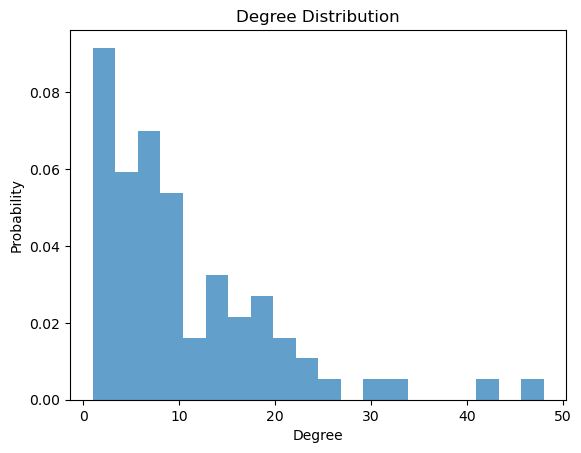

Calculating best minimal value for power law fit


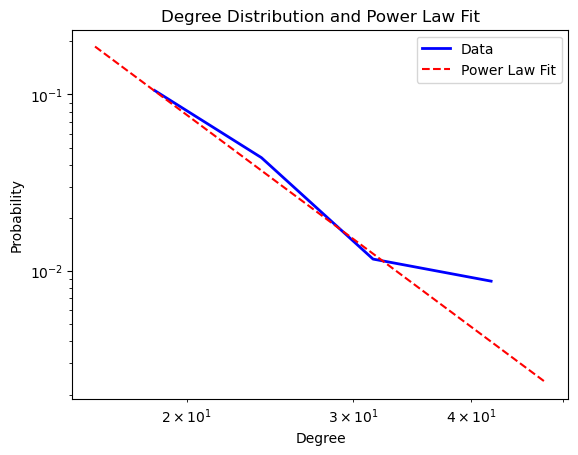

Power Law Fit Summary:
3.985874228004407
16.0
KS p-value: 0.08727671889761057


In [34]:
degree_sequence = [degree for node, degree in g.degree()]

plt.hist(degree_sequence, bins=20, density=True, alpha=0.7)
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.title("Degree Distribution")
plt.show()

fit = powerlaw.Fit(degree_sequence)

fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='r', linestyle='--', ax=plt.gca())
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.title("Degree Distribution and Power Law Fit")
plt.legend(['Data', 'Power Law Fit'])
plt.show()

print("Power Law Fit Summary:")
print(fit.power_law.alpha)
print(fit.power_law.xmin)
print("KS p-value:", fit.power_law.KS())
#print("Likelihood ratio p-value:", fit.power_law.distribution_compare('power_law', 'lognormal'))

### Validation

* row 1: El Chapo and El Mayo ruled the Sinaloa Cartel together (Mexico)
* row 2: El Mencho and Nem do not seem to have meaningful connections
* row 3: the two Calle Sernas are brothers
* row 4: Chepe Diablo and Chepe do not seem to have meaningful connections 
* row 5: Comba and Diego Rastrojo led the Rastrojos group together (Colombia)

In [35]:
#df_connections = pd.read_csv('_aux/Connections between individuals - alliances.csv')
df_connections.sort_values('weight',ascending=False).head(30)

,ind_1,ind_2,weight
3811,Joaquín Guzmán Loera,Ismael Zambada García,41
3812,Joaquín Guzmán Loera,Hector Manuel Beltran Leyva,23
3913,Luis Enrique Calle Serna,Javier Antonio Calle Serna,22
884,José Adán Salazar Umaña,Rafael Alvarez Piñeda,17
3910,Diego Perez Henao,Luis Enrique Calle Serna,16
635,Pablo Escobar,Diego Fernando Murillo Bejarano,15
3825,Ismael Zambada García,Hector Manuel Beltran Leyva,14
3911,Diego Perez Henao,Javier Antonio Calle Serna,14
580,Ariel Máximo Cantero,Joaquín Guzmán Loera,14
2626,Nemesio Rubén Oseguera Cervantes,Joaquín Guzmán Loera,12


# Groups